# Recognize a face and produce a unique ID

The goal of this project is to read images from a capture location on disk and identify faces. When a face is detected a unique ID will be produced for that face.

This may require creating a neural classification network for a face. This could be done automatically when a face can't be classified, in order to add people to the classificaiton automatically.

Using the face detection system from MS we can get a list of faces in an image. 

Then we just need to extract the faces from the image and apply a classification algorithm to it. If the classificaiton algorithm identifies the face, we can retrieve a unique ID for that face and send it to the color-wander to show them their own personalized art. 


# Setup a watch on the file system for new images

In [2]:
import sys
import time
import logging
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

In [3]:
class MyHandler(FileSystemEventHandler):
    def on_modified(self, event):
        print("Got it")


path = '/data'
event_handler = MyHandler()
observer = Observer()
observer.schedule(event_handler, path, recursive=True)
observer.start()
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    observer.stop()
observer.join()

# Run OpenCV facial recognition and produce hash code for all faces found

In [4]:
import time 
import requests
import cv2
import operator
import numpy as np

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [5]:
_url = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key = 'e4814164d0854397aa8bd43c406de8e1' #Here you have to paste your primary key
_maxNumRetries = 10

In [6]:
def processRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = None )

        if response.status_code == 429: 

            print("Message: %s" % ( response.json()['error']['message'] ))

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print('Error: failed after retrying!')
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print("Error code: %d" % ( response.status_code ))
            print("Message: %s" % ( response.json()['error']['message'] ))

        break
        
    return result

In [11]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

[{'faceRectangle': {'left': 260, 'height': 107, 'top': 143, 'width': 107}, 'scores': {'sadness': 4.530515e-06, 'contempt': 0.000771649939, 'happiness': 0.011670934, 'anger': 3.79946158e-07, 'neutral': 0.974952459, 'disgust': 4.190679e-07, 'fear': 3.16475081e-07, 'surprise': 0.0125993025}}]


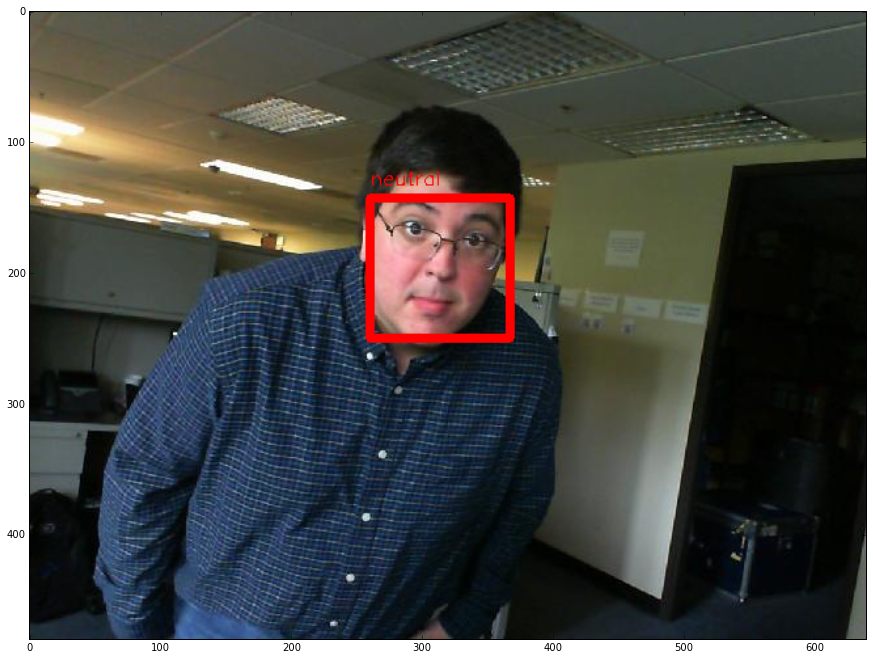

In [12]:
# Load raw image file into memory
pathToFileInDisk = r'/images/05-16 12.19.21.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

result = processRequest( json, data, headers )
print(result)
# Load the original image from disk
data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

renderResultOnImage( result, img )

ig, ax = plt.subplots(figsize=(15, 20))
ax.imshow( img )

# reduce a image of a face to a recognized hash code

# send a request to the color-wander service to use a given hash code